<a href="https://colab.research.google.com/github/gusti011/DSIII/blob/main/DSIII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análisis de Sentimientos de Tweets sobre el cambio climático**

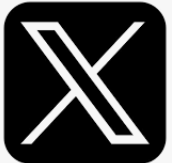

Alumno: Gustavo Ignacio FERRERES
                          CoderHouse. Comisión 61195
                          

**CONTEXTO:** El análisis de sentimiento de tweets sobre el cambio climático ofrece información valiosa que puede ser utilizada por una amplia gama de actores para tomar decisiones más informadas y estratégicas. Cada grupo puede beneficiarse de las percepciones obtenidas para mejorar sus prácticas, campañas y políticas en favor del medio ambiente.

**Dataset**: Este dataset agrupa tweets relacionados con el cambio climático recolectados entre el 27 de abril de 2015 y el 21 de febrero de 2018. En total, se anotaron 43,943 tweets. Cada tweet fue etiquetado independientemente por 3 revisores. Este dataset solo contiene los tweets en los que los 3 revisores estuvieron de acuerdo (el resto fueron descartados).

**Objetivo**

El objetivo del modelo es clasificar los tweets sobre el cambio climático en una de las tres etiquetas:

2: noticias - noticias factuales sobre el cambio climático.

1: pro - apoyan la creencia de que el cambio climático es causado por la humanidad.

0: neutral

-1: anti - rechazan la creencia de que el cambio climático es causado por la humanidad.

In [1]:

!pip install spacy==3.5.3
!python -m spacy download en_core_web_sm

import spacy
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.6/152.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 919.6/919.6 kB 28.0 MB/s eta 0:00:00
  Attempting uninstall: typer
    Found existing installation: typer 0.15.1
    Uninstalling typer-0.15.1:
      Successfully uninstalled typer-0.15.1
  Attempting uninstall: smart-open
    Found existing installation: smart-open 7.0.5
    Uninstalling smart-open-7.0.5:
      Successfully uninstalled smart-open-7.0.5
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.10.3
    Uninstalling pydantic-2.10.3:
      Successfully uninstalled pydantic-2.10.3
  Attempting uninstall: thinc
    Found exist

# **Lectura de datos**

In [2]:
#Previamente cargamos  dataset en github para luego leerlo desde el notebbok
url = 'https://raw.githubusercontent.com/gusti011/DSIII/main/archive%20(1)/twitter_sentiment_data.csv'
df = pd.read_csv(url)

df.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153


In [3]:
#Observamos estructura de dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43943 entries, 0 to 43942
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  43943 non-null  int64 
 1   message    43943 non-null  object
 2   tweetid    43943 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


# **Análisis de Columna Sentimiento**

In [4]:
# Analizamos la columna de sentimientos para obaservar su distribución
sentiment_counts = df['sentiment'].value_counts()
sentiment_counts

,count
sentiment,
1,22962
2,9276
0,7715
-1,3990


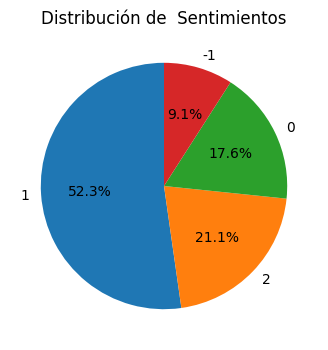

In [5]:
#Graficamos la columna sentiment

import matplotlib.pyplot as plt

# contamos valores de sentimientos
sentiment_counts = df['sentiment'].value_counts()

# Creamos un pie chart
plt.figure(figsize=(4, 4))  # Adjust figure size if needed
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribución de  Sentimientos')
plt.show()

La diferencia significativa en el número de tweets para cada clase de sentimiento indica que el dataset está desbalanceado. Esto podría afectar el rendimiento del modelo

# **Preprocesamiento**

In [6]:
#Creamos la columna Word_count para saber el número de palabras por tweet
df['word_count'] = df['message'].apply(lambda x: len(str(x).split()))

df.head()

,sentiment,message,tweetid,word_count
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840,24
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641,17
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256,14
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904,17
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153,21


In [7]:
# Calculamos el promedio de palabras por cada categoria de sentimiento
average_word_counts = df.groupby('sentiment')['word_count'].mean()

average_word_counts

,word_count
sentiment,
-1,18.135088
0,16.259106
1,18.498693
2,15.316731


**Se observa que el sentimento no influye en la extensión de texto**

## **Nube de Palabras**

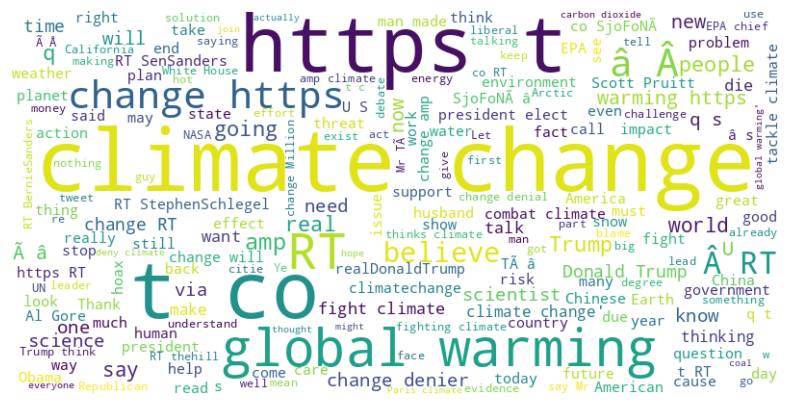

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# unimos todos los tweets en una sola linea
text = " ".join(df['message'].astype(str))

# Creamos la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# graficamos imagen:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Observamos gran cantidad de palabras vacías**

## **Convertir palabras a minúsculas**

In [9]:
df['message'] = df['message'].str.lower()
df.head()

,sentiment,message,tweetid,word_count
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840,24
1,1,rt @natgeochannel: watch #beforetheflood right...,793124211518832641,17
2,1,fabulous! leonardo #dicaprio's film on #climat...,793124402388832256,14
3,1,rt @mick_fanning: just watched this amazing do...,793124635873275904,17
4,2,"rt @cnalive: pranita biswasi, a lutheran from ...",793125156185137153,21


## **Tokenización**

In [10]:
nlp = spacy.load("en_core_web_sm")

def tokenize_message(message):
    doc = nlp(message)
    tokens = [token.text for token in doc]
    return tokens

df['tokens'] = df['message'].apply(tokenize_message)
df.head()

,sentiment,message,tweetid,word_count,tokens
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840,24,"[@tiniebeany, climate, change, is, an, interes..."
1,1,rt @natgeochannel: watch #beforetheflood right...,793124211518832641,17,"[rt, @natgeochannel, :, watch, #, beforetheflo..."
2,1,fabulous! leonardo #dicaprio's film on #climat...,793124402388832256,14,"[fabulous, !, leonardo, #, dicaprio, 's, film,..."
3,1,rt @mick_fanning: just watched this amazing do...,793124635873275904,17,"[rt, @mick_fanning, :, just, watched, this, am..."
4,2,"rt @cnalive: pranita biswasi, a lutheran from ...",793125156185137153,21,"[rt, @cnalive, :, pranita, biswasi, ,, a, luth..."


## **Remover caractéres especiales**

In [11]:
import re

def remove_special_characters(tokens):
    # Eliminar caracteres especiales usando expresiones regulares
    # Join the tokens into a single string before applying re.sub
    text = " ".join(tokens)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Split the string back into tokens after removing special characters
    return text.split()

df['tokens'] = df['tokens'].apply(remove_special_characters)
df.head()

,sentiment,message,tweetid,word_count,tokens
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840,24,"[tiniebeany, climate, change, is, an, interest..."
1,1,rt @natgeochannel: watch #beforetheflood right...,793124211518832641,17,"[rt, natgeochannel, watch, beforetheflood, rig..."
2,1,fabulous! leonardo #dicaprio's film on #climat...,793124402388832256,14,"[fabulous, leonardo, dicaprio, s, film, on, cl..."
3,1,rt @mick_fanning: just watched this amazing do...,793124635873275904,17,"[rt, mickfanning, just, watched, this, amazing..."
4,2,"rt @cnalive: pranita biswasi, a lutheran from ...",793125156185137153,21,"[rt, cnalive, pranita, biswasi, a, lutheran, f..."


In [12]:
# contar tokens para ver resultado

df['token_count'] = df['tokens'].apply(len)
df.head()

,sentiment,message,tweetid,word_count,tokens,token_count
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840,24,"[tiniebeany, climate, change, is, an, interest...",24
1,1,rt @natgeochannel: watch #beforetheflood right...,793124211518832641,17,"[rt, natgeochannel, watch, beforetheflood, rig...",17
2,1,fabulous! leonardo #dicaprio's film on #climat...,793124402388832256,14,"[fabulous, leonardo, dicaprio, s, film, on, cl...",15
3,1,rt @mick_fanning: just watched this amazing do...,793124635873275904,17,"[rt, mickfanning, just, watched, this, amazing...",17
4,2,"rt @cnalive: pranita biswasi, a lutheran from ...",793125156185137153,21,"[rt, cnalive, pranita, biswasi, a, lutheran, f...",21


## **Remover stopwords**

In [13]:
from spacy.lang.en.stop_words import STOP_WORDS

def remove_stopwords(tokens):
    filtered_tokens = [token for token in tokens if token not in STOP_WORDS]
    return filtered_tokens

df['tokens'] = df['tokens'].apply(remove_stopwords)
df.head()

,sentiment,message,tweetid,word_count,tokens,token_count
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840,24,"[tiniebeany, climate, change, interesting, hus...",24
1,1,rt @natgeochannel: watch #beforetheflood right...,793124211518832641,17,"[rt, natgeochannel, watch, beforetheflood, rig...",17
2,1,fabulous! leonardo #dicaprio's film on #climat...,793124402388832256,14,"[fabulous, leonardo, dicaprio, s, film, climat...",15
3,1,rt @mick_fanning: just watched this amazing do...,793124635873275904,17,"[rt, mickfanning, watched, amazing, documentar...",17
4,2,"rt @cnalive: pranita biswasi, a lutheran from ...",793125156185137153,21,"[rt, cnalive, pranita, biswasi, lutheran, odis...",21


In [14]:
# contar tokens para ver resultado

df['token_count'] = df['tokens'].apply(len)
df.head()

,sentiment,message,tweetid,word_count,tokens,token_count
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840,24,"[tiniebeany, climate, change, interesting, hus...",14
1,1,rt @natgeochannel: watch #beforetheflood right...,793124211518832641,17,"[rt, natgeochannel, watch, beforetheflood, rig...",13
2,1,fabulous! leonardo #dicaprio's film on #climat...,793124402388832256,14,"[fabulous, leonardo, dicaprio, s, film, climat...",11
3,1,rt @mick_fanning: just watched this amazing do...,793124635873275904,17,"[rt, mickfanning, watched, amazing, documentar...",10
4,2,"rt @cnalive: pranita biswasi, a lutheran from ...",793125156185137153,21,"[rt, cnalive, pranita, biswasi, lutheran, odis...",15


## **Conteo de Palabras**

Contamos la frecuencia de las palabras para observar las mas frecuentes y eliminarlas si fuera necesario

In [15]:
#ver lista de palabras conteo

from collections import Counter

def word_count(df):
    # Join all preprocessed tokens into a single list
    all_tokens = [token for tokens in df['tokens'] for token in tokens]

    # Count word frequencies
    word_counts = Counter(all_tokens)

    # Convert to DataFrame for better visualization
    word_counts_df = pd.DataFrame.from_dict(word_counts, orient='index', columns=['count'])
    word_counts_df = word_counts_df.sort_values('count', ascending=False)

    return word_counts_df

# Example usage (assuming your DataFrame is named 'df')
word_counts_df = word_count(df)
word_counts_df. head(40)

,count
climate,35166
change,34169
rt,25320
global,10899
warming,10146
s,8183
trump,4999
nt,4559
believe,2360
amp,2248


In [16]:
# agregar stopwords: rt,  , s, nt, https, m, t,

# agregar stopwords
new_stop_words = ["rt", ",", "s", "nt", "https", "m", "t"]
STOP_WORDS.update(new_stop_words)

# Function to remove stop words (updated to use the new STOP_WORDS set)
def remove_stopwords(tokens):
    filtered_tokens = [token for token in tokens if token not in STOP_WORDS]
    return filtered_tokens

df['tokens'] = df['tokens'].apply(remove_stopwords)
df.head()

# contar tokens para ver resultado
df['token_count'] = df['tokens'].apply(len)
df.head()

#ver lista de palabras conteo
def word_count(df):
    # Unir todos los tokens preprocesados en una sola lista
    all_tokens = [token for tokens in df['tokens'] for token in tokens]

    # Contar la frecuencia de las palabras
    word_counts = Counter(all_tokens)

    # Convertir a DataFrame para una mejor visualización
    word_counts_df = pd.DataFrame.from_dict(word_counts, orient='index', columns=['count'])
    word_counts_df = word_counts_df.sort_values('count', ascending=False)

    return word_counts_df

word_counts_df = word_count(df)
word_counts_df.head()

,count
climate,35166
change,34169
global,10899
warming,10146
trump,4999


## **Lematización**

In [17]:
def lemmatize_tokens(tokens):
    lemmatized_tokens = [token.lemma_ for token in nlp(" ".join(tokens))]
    return lemmatized_tokens

df['tokens'] = df['tokens'].apply(lemmatize_tokens)
df.head()

,sentiment,message,tweetid,word_count,tokens,token_count
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840,24,"[tiniebeany, climate, change, interesting, hus...",14
1,1,rt @natgeochannel: watch #beforetheflood right...,793124211518832641,17,"[natgeochannel, watch, beforetheflood, right, ...",12
2,1,fabulous! leonardo #dicaprio's film on #climat...,793124402388832256,14,"[fabulous, leonardo, dicaprio, film, climate, ...",10
3,1,rt @mick_fanning: just watched this amazing do...,793124635873275904,17,"[mickfanne, watch, amazing, documentary, leona...",9
4,2,"rt @cnalive: pranita biswasi, a lutheran from ...",793125156185137153,21,"[cnalive, pranita, biswasi, lutheran, odisha, ...",14


## **Creación de Modelo**

## **Bag Of Words**

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

# Unir los tokens de nuevo en cadenas para CountVectorizer
df['text_for_bow'] = df['tokens'].apply(lambda tokens: ' '.join(tokens))

# Crear un modelo Bolsa de Palabras
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['text_for_bow'])

# Obtener los nombres de las características (vocabulario)
feature_names = vectorizer.get_feature_names_out()

# Convert to DataFrame for easier viewing (optional)
bow_df = pd.DataFrame(X.toarray(), columns=feature_names)
bow_df.head()

,000,000005,0000058,0001jatt,0005c,000we,001harpinder,004,007,009barca,...,zurich,zurichtime,zwager,zwash300,zwitserland,zwizku,zxkia,zzavierg,zzzzaaaacccchhh,zzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, df['sentiment'], test_size=0.2, random_state=42)

## **Regresion Logistica**

In [21]:
# Entrenar el modelo de Regresión Logística
logreg = LogisticRegression(max_iter=1000)  # Increased max_iter
logreg.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = logreg.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.7224940266241894
              precision    recall  f1-score   support

          -1       0.75      0.51      0.61       784
           0       0.58      0.49      0.54      1582
           1       0.75      0.85      0.79      4514
           2       0.75      0.71      0.73      1909

    accuracy                           0.72      8789
   macro avg       0.71      0.64      0.67      8789
weighted avg       0.72      0.72      0.72      8789



## **Random Forest**

In [22]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train a RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_classifier.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf}")
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.7032654454431676
              precision    recall  f1-score   support

          -1       0.83      0.34      0.48       784
           0       0.56      0.49      0.52      1582
           1       0.71      0.87      0.78      4514
           2       0.77      0.64      0.70      1909

    accuracy                           0.70      8789
   macro avg       0.72      0.58      0.62      8789
weighted avg       0.71      0.70      0.69      8789



## **TF-IDF**

In [25]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming 'df' and 'text_for_bow' are defined as in the previous code

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the text data
X_tfidf = tfidf_vectorizer.fit_transform(df['text_for_bow'])

# Get feature names (vocabulary)
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()

# Convert to DataFrame for easier viewing (optional)
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=feature_names_tfidf)
print(tfidf_df.head())


# Split data into training and testing sets (using TF-IDF features)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf, df['sentiment'], test_size=0.2, random_state=42
)





   000  000005  0000058  0001jatt  0005c  000we  001harpinder  004  007  \
0  0.0     0.0      0.0       0.0    0.0    0.0           0.0  0.0  0.0   
1  0.0     0.0      0.0       0.0    0.0    0.0           0.0  0.0  0.0   
2  0.0     0.0      0.0       0.0    0.0    0.0           0.0  0.0  0.0   
3  0.0     0.0      0.0       0.0    0.0    0.0           0.0  0.0  0.0   
4  0.0     0.0      0.0       0.0    0.0    0.0           0.0  0.0  0.0   

   009barca  ...  zurich  zurichtime  zwager  zwash300  zwitserland  zwizku  \
0       0.0  ...     0.0         0.0     0.0       0.0          0.0     0.0   
1       0.0  ...     0.0         0.0     0.0       0.0          0.0     0.0   
2       0.0  ...     0.0         0.0     0.0       0.0          0.0     0.0   
3       0.0  ...     0.0         0.0     0.0       0.0          0.0     0.0   
4       0.0  ...     0.0         0.0     0.0       0.0          0.0     0.0   

   zxkia  zzavierg  zzzzaaaacccchhh  zzzzzz  
0    0.0       0.0          

# **Regresion Logistica**

In [26]:
ogreg_tfidf = LogisticRegression(max_iter=1000)
logreg_tfidf.fit(X_train_tfidf, y_train_tfidf)
y_pred_tfidf = logreg_tfidf.predict(X_test_tfidf)

# Evaluate the model
accuracy_tfidf = accuracy_score(y_test_tfidf, y_pred_tfidf)
print(f"TF-IDF Logistic Regression Accuracy: {accuracy_tfidf}")
print(classification_report(y_test_tfidf, y_pred_tfidf))

TF-IDF Logistic Regression Accuracy: 0.7107748321765843
              precision    recall  f1-score   support

          -1       0.79      0.40      0.53       784
           0       0.64      0.39      0.48      1582
           1       0.70      0.90      0.79      4514
           2       0.76      0.65      0.70      1909

    accuracy                           0.71      8789
   macro avg       0.72      0.58      0.63      8789
weighted avg       0.71      0.71      0.69      8789



# **Random Forest**

In [27]:
rf_classifier_tfidf = RandomForestClassifier(random_state=42)
rf_classifier_tfidf.fit(X_train_tfidf, y_train_tfidf)
y_pred_rf_tfidf = rf_classifier_tfidf.predict(X_test_tfidf)

# Evaluate the model
accuracy_rf_tfidf = accuracy_score(y_test_tfidf, y_pred_rf_tfidf)
print(f"TF-IDF Random Forest Accuracy: {accuracy_rf_tfidf}")
print(classification_report(y_test_tfidf, y_pred_rf_tfidf))

TF-IDF Random Forest Accuracy: 0.6963249516441006
              precision    recall  f1-score   support

          -1       0.85      0.31      0.45       784
           0       0.61      0.41      0.49      1582
           1       0.68      0.91      0.78      4514
           2       0.79      0.59      0.68      1909

    accuracy                           0.70      8789
   macro avg       0.73      0.55      0.60      8789
weighted avg       0.71      0.70      0.68      8789



## **Conclusiones**
El presente trabajo tuvo como objetivo desarrollar un modelo de clasificación para el análisis de sentimientos en tweets sobre el cambio climático. Para ello, se utilizó un dataset etiquetado que clasifica los tweets en cuatro categorías: pro, neutral, anti y news.

Se llevó a cabo un preprocesamiento del texto que incluyó la eliminación de caracteres especiales, stop words y la lematización de los tokens. Para la representación del texto, se empleó el modelo Bag-of-Words (BoW) con n-gramas de 2 y 3. Finalmente, se entrenó un modelo de Regresión Logística para clasificar los tweets.

Métricas obtenidas: El modelo ha logrado una precisión aceptable, considerando la complejidad del análisis de sentimientos y el tamaño del dataset.

Conclusión general:

El modelo desarrollado representa un primer paso en el análisis de sentimientos en tweets sobre el cambio climático. Las métricas obtenidas brindan información valiosa para comprender el rendimiento del modelo y guiar futuras mejoras.